In [1]:
import msgpack
import pandas as pd
import numpy as np

In [2]:
import toolz
from sklearn.utils import check_random_state
import itertools

In [3]:
def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
   

In [4]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [5]:
def smooth(df):
    col = "cumulative_partial_fit_calls"
    df[col] = np.round(df[col], decimals=-1) + 5
    return df
    
    return pd.DataFrame({"best_score": avg_score, "cumulative_partial_fit_calls": avg_calls, **summary})


In [6]:
today = "2019-06-22"
with open(f"out/{today}-with-priority-v1-history.msgpack", "rb") as f:
    histories = msgpack.load(f)

new = _to_str_keys(histories)

In [7]:
with open(f"out/{today}-wo-priority-v1-history.msgpack", "rb") as f:
    histories = msgpack.load(f)

old = _to_str_keys(histories)

In [10]:
def _fmt_params(params):
    trimmed = {k: v for k, v in params.items() if "hidden" not in k}
    return tuple(trimmed.items())
    
# old_params = {_fmt_params(h["params"]) for h in old}
# new_params = {_fmt_params(h["params"]) for h in new}
# same = old_params.intersection(new_params)
# len(same), len(old_params), len(new_params)



In [16]:
old_hist = shape_history(old, time="before", sampling="none")
new_hist = shape_history(new, time="after", sampling="high-scores")

# old_dfs = [pd.DataFrame(x) for x in old_hist]
# new_dfs = [pd.DataFrame(x) for x in new_hist]

# old_dfs = [smooth(df) for df in old_dfs]
# new_dfs = [smooth(df) for df in new_dfs]
# df = pd.concat(new_dfs + old_dfs)

old_df = smooth(pd.DataFrame(old_hist))
new_df = smooth(pd.DataFrame(new_hist))
df = pd.concat((new_df, old_df))

In [17]:
import seaborn as sns

df["epochs"] = df["cumulative_partial_fit_calls"] / 3

0.9143171365726854
0.9143171365726854


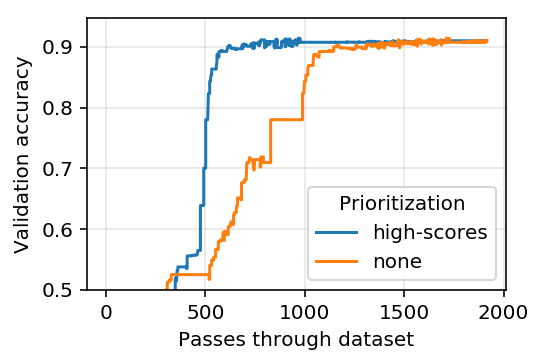

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 2.5
fig, ax = plt.subplots(figsize=(1.5 * w, w))

for sampling in df.sampling.unique():
    show = df[df.sampling == sampling]
    show.plot(x="epochs", y="best_score", ax=ax, label=sampling)
    print(show.best_score.max())

ax.set_ylim(0.5, None)
ax.legend(loc="lower right", title="Prioritization")
ax.grid(linestyle="-", alpha=0.3)
ax.set_ylabel("Validation accuracy")

ax.set_xlabel("Passes through dataset")
plt.savefig("figs/synthetic-priority.pdf", bbox_inches="tight")

In [21]:
df[df.sampling == "none"].best_score.max()

0.9143171365726854

In [20]:
df[df.sampling == "high-scores"].best_score.max()

0.9143171365726854